In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset import cifar10
from vision import util

Files already downloaded and verified


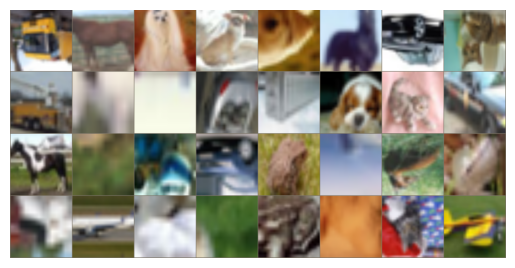

In [2]:
dataset = cifar10.CIFAR10DataSet()
downloader = dataset.train_dataloader()
images, labels = dataset.get_batch(downloader)
util.show_images(images, dataset.mean, dataset.std)